In [1]:
%load_ext autoreload
%autoreload 2

## Load modules
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import sys
sys.path.append('/home/freimax/msc_thesis/scripts/helpers/')
from data_preprocessing_helpers import get_lonlatbox
sys.path.append('/home/freimax/msc_thesis/scripts/plotting_functions/')
from plot_functions import plot_cross_section, draw_color_blocks, add_inset_plot
sys.path.append('/home/freimax/msc_thesis/scripts/random_forest/')
import rf_functions

import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

In [11]:
## Load Data
lonrange = [135,-165]
latrange = [20,70]


path = '/net/thermo/atmosdyn2/atroman/PACaccu/cdf'

ds_p_all = xr.open_mfdataset(f'{path}/P*')
ds_p_all = ds_p_all.squeeze('lev2')
da_rh = xr.open_dataset('/home/freimax/msc_thesis/data/case_study_ra19/model_level_coord/RH_ifs.nc')

## Lonlatbox  -- apply to model-level data
ds_p = get_lonlatbox(ds_p_all, lon_range=lonrange, lat_range=latrange)
ds_p['tsubsi']  = ds_p['tsubs'] + ds_p['tsubi']

ds_p['tmeltsi'] = ds_p['tmelts']+ ds_p['tmelti']
ds_p['SIWC']    = ds_p['SWC']+ ds_p['IWC']
ds_p['RH_ifs']  = da_rh['RH_ifs']

In [54]:
## Filter data

# Drop all SIWC values = 0 for sublimation field
da_sub_filt = ds_p['tsubsi'].where(ds_p['SIWC'] != 0, drop=True)


In [55]:
da_melt_filt = ds_p['tmeltsi'].where((ds_p['SIWC'] != 0) & (ds_p['T'] < 0), drop=True)
da_ev_filt = ds_p['tevr'].where((ds_p['RWC'] != 0) & (ds_p['T'] > 0), drop=True)

In [57]:
array_sub_filt = da_sub_filt.values.flatten()
array_sub_filt = array_sub_filt[~np.isnan(array_sub_filt)]

array_melt_filt = da_melt_filt.values.flatten()
array_melt_filt = array_melt_filt[~np.isnan(array_melt_filt)]


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [59]:
array_ev_filt = da_ev_filt.values.flatten()
array_ev_filt = array_ev_filt[~np.isnan(array_ev_filt)]

In [60]:
array_sub_filt2  = array_sub_filt[array_sub_filt < -0.001]
array_melt_filt2 = array_melt_filt[array_melt_filt < -0.001]
array_evap_filt2 = array_ev_filt[array_ev_filt < -0.001]

In [61]:
# Randomly subsample 10000 elements from the array
sub_subsample  = np.random.choice(array_sub_filt2, size=int(array_sub_filt2.shape[0]/5), replace=False)
melt_subsample = np.random.choice(array_melt_filt2, size=int(array_melt_filt2.shape[0]/5), replace=False)
evap_subsample = np.random.choice(array_evap_filt2, size=int(array_evap_filt2.shape[0]/5), replace=False)

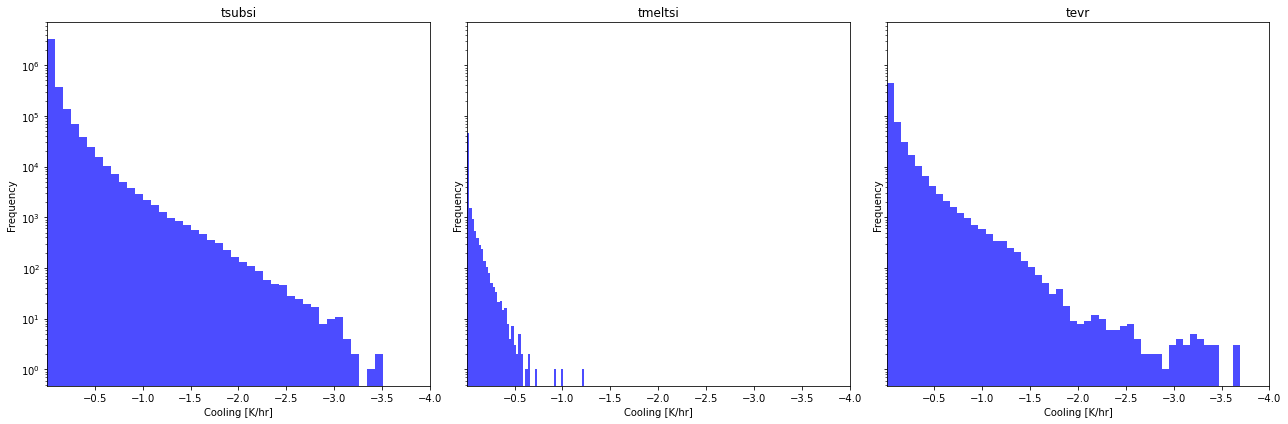

In [65]:
subsamples = [sub_subsample, melt_subsample, evap_subsample] 

def plot_histograms(data_list, title_list, bins=50):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # Adjust the size as needed

    for i, data in enumerate(data_list):
        axs[i].hist(data, bins=bins, color='blue', alpha=0.7, log=True)
        axs[i].set_xlim(-0.001, -4)
        axs[i].set_title(title_list[i])
        axs[i].set_xlabel('Cooling [K/hr]')
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_histograms(subsamples, title_list=['tsubsi', 'tmeltsi', 'tevr'])